<a href="https://colab.research.google.com/github/jzyee/CM1101/blob/master/models/LSTM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
% cd /content/gdrive/'My Drive'/water_stress_detection

/content/gdrive/My Drive/water_stress_detection


# imports

In [116]:
# multivariate multi-step data preparation
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import Bidirectional
import tensorflow as tf
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from sklearn import preprocessing
import time

import os
os.environ["KERAS_BACKEND"] = "theano"

plt.rcParams["figure.figsize"] = (18,6)

# helper

In [117]:
def combine_eob(site_id):
  '''
  RR - daily sum preciptation
  PP - daily sea level pressure
  TG - daily mean temp
  TN - daily min temp
  TX - daily max temp
  
  '''
  type_list = ['pp', 'rr', 'tg', 'tn', 'tx']

  folder_path = 'data_files/monthly_means/'

  # file naming convention
  # file_cov = 'wind_monthly_'
  # file_name = 'SWIT345'

  start_name_cov = 'monthly_mean_'
  end_name_cov = '_EBTRN'

  out_df = None

  for idx, data_type in enumerate(type_list):
    file_path = folder_path + start_name_cov + data_type + end_name_cov + '.csv'
    if idx == 0:
      df = pd.read_csv(file_path, parse_dates=True).set_index(['Date'])[[site_id]]
      df = df.rename(columns={site_id: data_type})
    
    else:
      df[data_type] = pd.read_csv(file_path, parse_dates=True).set_index(['Date'])[site_id]

  
  return df

def get_climate_and_ndvi(site_id):
  harm_df = pd.read_csv('data_files/processed_harm_ndvi.csv', parse_dates=True)
  harm_df.index = pd.to_datetime(harm_df.iloc[:,0], format='%Y-%m-%d') 
  harm_df = harm_df.iloc[:,1:]
  harm_df.index.name = 'Date'
  # filter out the useable dates
  harm_df = harm_df.loc[(harm_df.index > '1986') & (harm_df.index < '2019')]
  # get the climate data
  df = combine_eob(site_id)
  df = df.loc[(df.index > '1986') & (df.index < '2019')]

  df['ndvi'] = harm_df[site_id]
  return df

def format_cols_casualimpact(df, y_col_name):
  '''
  description: formating column names to fit casual impact function

                example of format:
                data = pd.DataFrame({'x0': x0, 'x1': x1, 'y': y}, 
                                     columns=['y', 'x0', 'x1'])

  returns: dataframe with correct columns names as seen in example

  '''
  old_list = df.columns.to_list()
  new_cols = {}
  
  for idx, col in enumerate(old_list):
    if col != y_col_name:
      new_cols['x'+str(idx)] = col
    else:
      new_cols['y'] = y_col_name

  df.columns = new_cols
  
  #rearranging cols
  rearrange_cols = list([df.columns[-1]]) + list(df.columns[:-1])
  df = df[rearrange_cols]

  return(df)

def make_folder(filename='init_LSTM_model.h5'):

  folder_path = '/model_data/' 
  file_loc = folder_path + filename
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

  return file_loc

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
def plot_history(history):
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('epochs')
  plt.ylabel('loss(MSE)')
  plt.legend()

def format_spei(spei_df):
  spei_df.index = spei_df['siteID']
  spei_df = spei_df.iloc[:,1:].T
  spei_df.index = pd.to_datetime(spei_df.index, format='x%Y.%m.%d')
  spei_df.index = spei_df.index.rename('date') 
  spei_df = spei_df.resample('M').mean()
  #full years only
  spei_df = spei_df.loc[(spei_df.index > '1986') & (spei_df.index < '2020')]
  return spei_df

def get_climate_ndvi_and_spei(site):
  spei_df = pd.read_csv('SPEI_folder/SPEI_monthly_EBTRNsites.csv', parse_dates=True)
  spei_df = format_spei(spei_df)

  climate_ndvi = get_climate_and_ndvi(site)
  climate_ndvi['spei'] = spei_df[site]

  return climate_ndvi


sites_of_interest = ["MOT", "ALWB", "CEA", "E45", "FSAR", "FSGA", "GoS", "SAGB",  "UK28", "UK53"]

site =  'SWIT345'
raw_data = get_climate_ndvi_and_spei(site)
display(raw_data)

,pp,rr,tg,tn,tx,ndvi,spei
Date,,,,,,,
1986-01-31,1013.900015,4.864516,0.975806,-1.707742,4.251935,0.318780,2.142240
1986-02-28,1011.242872,1.735714,-1.354286,-3.848571,1.692143,0.230058,-0.796624
1986-03-31,1017.496789,1.303226,5.091613,1.864516,9.023226,0.141337,-0.135434
1986-04-30,1010.876682,14.556667,6.509667,3.884333,9.810333,0.338837,2.488159
1986-05-31,1017.780660,5.577419,15.047096,10.819677,20.320645,0.623102,0.452782
...,...,...,...,...,...,...,...
2018-08-31,1015.622596,4.951613,21.207419,16.348709,27.032257,0.830514,-0.727648
2018-09-30,1019.583349,0.940000,17.796333,13.199000,23.126333,0.832393,-1.539532
2018-10-31,1017.651628,9.716129,13.152258,9.296451,17.583225,0.760072,-0.686977


# normalize data

In [118]:

def norm_raw_data(raw_data):
  norm_data = raw_data.copy()

  for col in raw_data:
    if col not in ['ndvi', 'spei']:
      min_max_scaler = preprocessing.MinMaxScaler()
      norm_data[col] = min_max_scaler.fit_transform(raw_data[[col]].values)

  return norm_data

norm_data = norm_raw_data(raw_data)
norm_data

,pp,rr,tg,tn,tx,ndvi,spei
Date,,,,,,,
1986-01-31,0.294818,0.224793,0.092675,0.094287,0.092787,0.318780,2.142240
1986-02-28,0.195778,0.080209,0.000000,0.000000,0.000000,0.230058,-0.796624
1986-03-31,0.428881,0.060223,0.256373,0.251619,0.265736,0.141337,-0.135434
1986-04-30,0.182129,0.672674,0.312773,0.340576,0.294267,0.338837,2.488159
1986-05-31,0.439461,0.257737,0.652332,0.646026,0.675243,0.623102,0.452782
...,...,...,...,...,...,...,...
2018-08-31,0.359024,0.228818,0.897347,0.889539,0.918524,0.830514,-0.727648
2018-09-30,0.506653,0.043438,0.761678,0.750818,0.776943,0.832393,-1.539532
2018-10-31,0.434652,0.448989,0.576969,0.578940,0.576017,0.760072,-0.686977


# model build

# splitting data into train, val, test

In [119]:
dataset = norm_data
ttl_len = len(dataset)
train = np.array(dataset.iloc[:int(ttl_len * 0.7)])
val = np.array(dataset.iloc[int(ttl_len * 0.7):int(ttl_len * 0.8)])
test = np.array(dataset.iloc[int(ttl_len * 0.8):])

print(train.shape)
print(val.shape)
print(test.shape)

(277, 7)
(39, 7)
(80, 7)


In [120]:
n_steps_in, n_steps_out = 12, 6

train_X, train_y = split_sequences(train, n_steps_in, n_steps_out)
val_X, val_y = split_sequences(val, n_steps_in, n_steps_out)
test_X, test_y = split_sequences(test, n_steps_in, n_steps_out)

# print(test)

n_features = train_X.shape[2]
print(n_features)

7


# initial model training 

## steps in = 12 , steps out 6

In [121]:
n_steps_in, n_steps_out = 12, 6

train_X, train_y = split_sequences(train, n_steps_in, n_steps_out)
val_X, val_y = split_sequences(val, n_steps_in, n_steps_out)
test_X, test_y = split_sequences(test, n_steps_in, n_steps_out)

# print(test)

n_features = train_X.shape[2]
print(n_features)

7


stacked LSTM autoencoder

time taken: 48.58982599999945
1/1 [==============================] - 0s 1ms/step - loss: 0.1775
val loss: 0.1774541288614273
2/2 [==============================] - 0s 9ms/step - loss: 0.1652
test loss: 0.16516265273094177


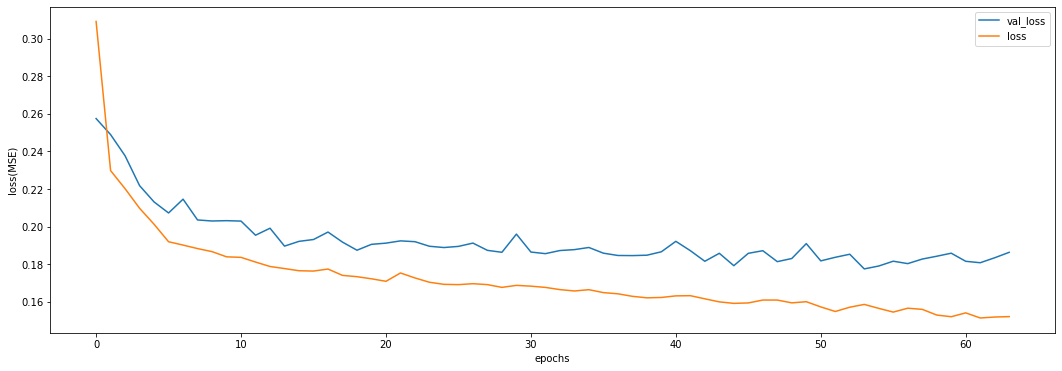

In [123]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
# fit model
t0= time.clock()
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[mc,es])
t1= time.clock() - t0
print('time taken:', t1)
saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

time taken: 16.900932000000466
1/1 [==============================] - 0s 1ms/step - loss: 0.1838
val loss: 0.1838475614786148
2/2 [==============================] - 0s 4ms/step - loss: 0.1710
test loss: 0.1709509938955307


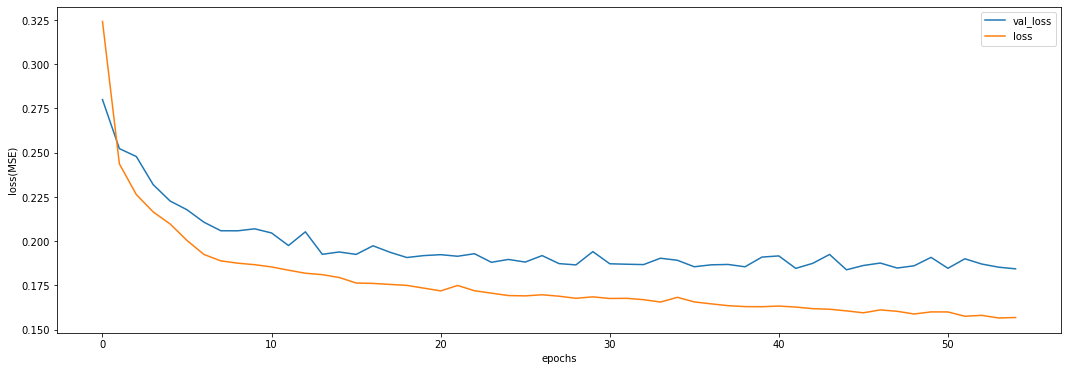

In [124]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)

saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

stacked bilstm (200,200)

time taken: 58.34726899999987
1/1 [==============================] - 0s 2ms/step - loss: 0.1800
val loss: 0.18000465631484985
2/2 [==============================] - 0s 16ms/step - loss: 0.1647
test loss: 0.164695143699646


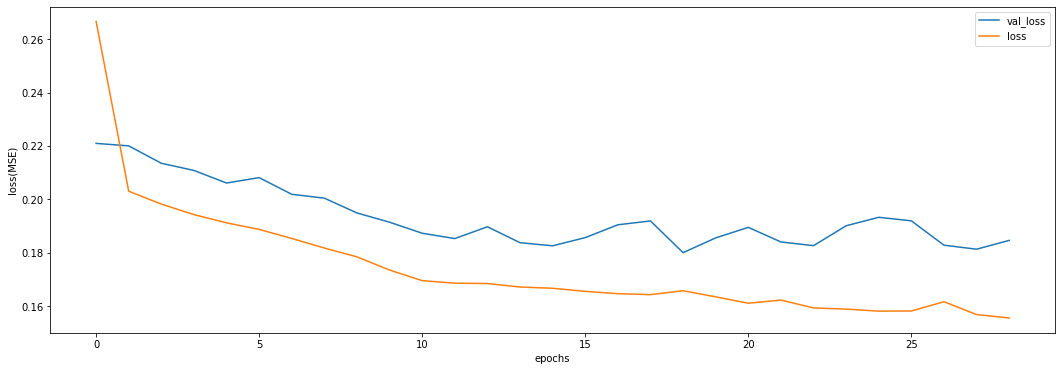

In [125]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features))))
model.add(RepeatVector(n_steps_out))
model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)


saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

stacked bilstm (100,100)

time taken: 20.842428999999356
1/1 [==============================] - 0s 1ms/step - loss: 0.1793
val loss: 0.17932918667793274
2/2 [==============================] - 0s 6ms/step - loss: 0.1662
test loss: 0.1662227362394333


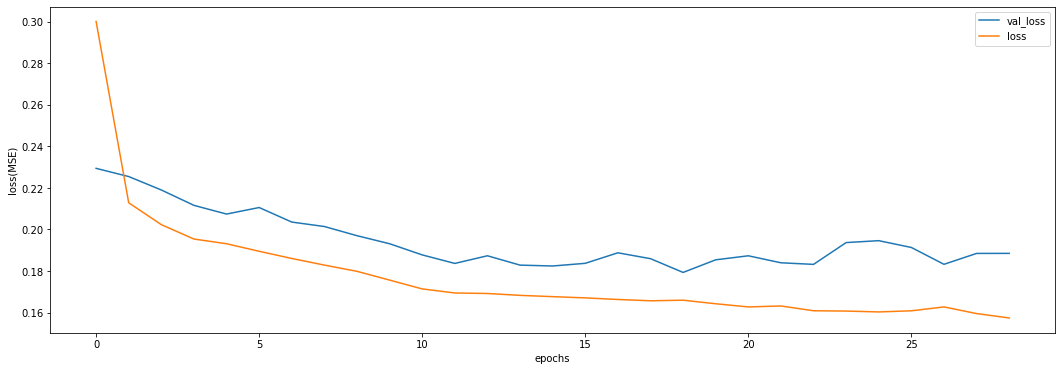

In [126]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features))))
model.add(RepeatVector(n_steps_out))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)

saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

## steps = 12, steps out 12

In [132]:
n_steps_in, n_steps_out = 12, 12

train_X, train_y = split_sequences(train, n_steps_in, n_steps_out)
val_X, val_y = split_sequences(val, n_steps_in, n_steps_out)
test_X, test_y = split_sequences(test, n_steps_in, n_steps_out)

# print(test)

n_features = train_X.shape[2]
print(n_features)

7


time taken: 20.055285000000367
1/1 [==============================] - 0s 2ms/step - loss: 0.1685
val loss: 0.1685001105070114
2/2 [==============================] - 0s 5ms/step - loss: 0.1637
test loss: 0.16370391845703125


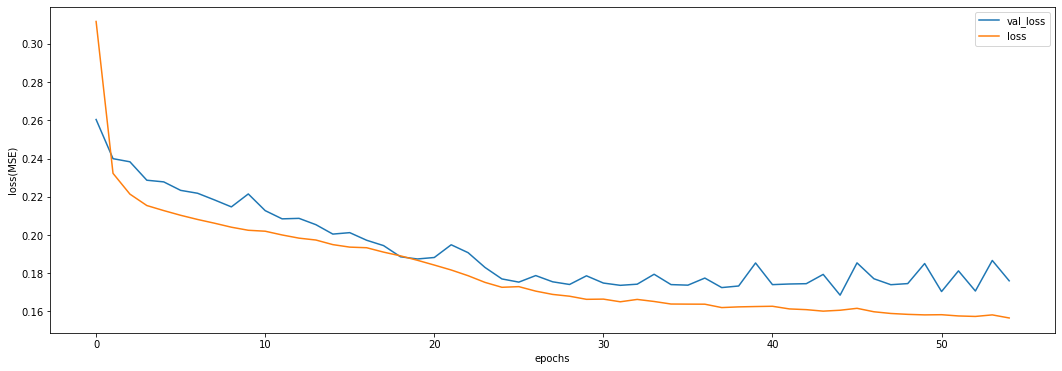

In [128]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)

saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

time taken: 47.483438999999635
1/1 [==============================] - 0s 1ms/step - loss: 0.1641
val loss: 0.16414014995098114
2/2 [==============================] - 0s 11ms/step - loss: 0.1611
test loss: 0.16107332706451416


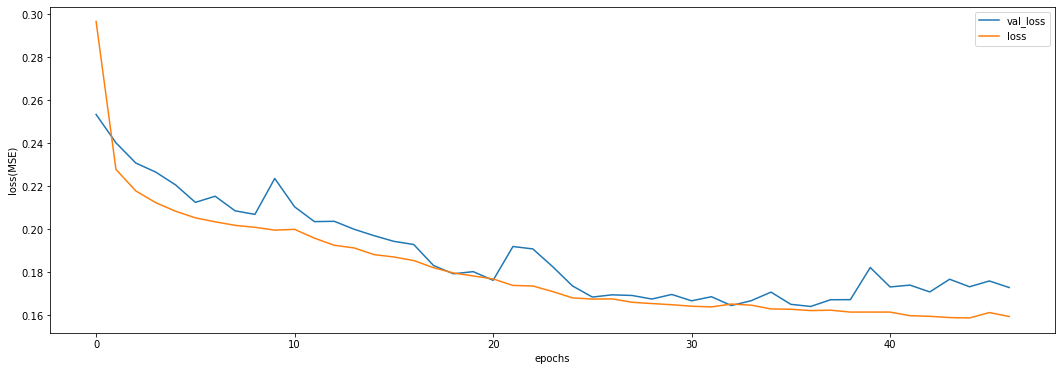

In [133]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder('best_LSTM.h5')
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)

saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)


time taken: 34.64371500000016
1/1 [==============================] - 0s 1ms/step - loss: 0.1697
val loss: 0.16972345113754272
2/2 [==============================] - 0s 7ms/step - loss: 0.1629
test loss: 0.16291314363479614


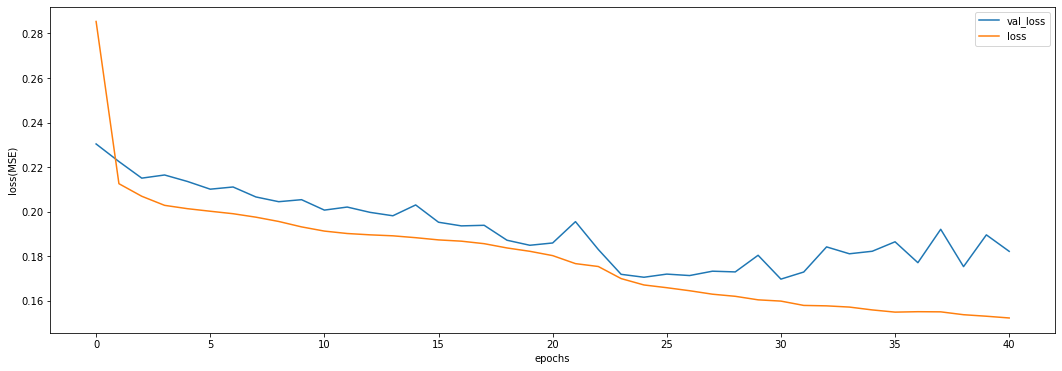

In [130]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features))))
model.add(RepeatVector(n_steps_out))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)

saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

1/1 [==============================] - 0s 1ms/step - loss: 0.1618
val loss: 0.1618497371673584
2/2 [==============================] - 0s 21ms/step - loss: 0.1692
test loss: 0.16920800507068634
time taken: 137.90207999999984


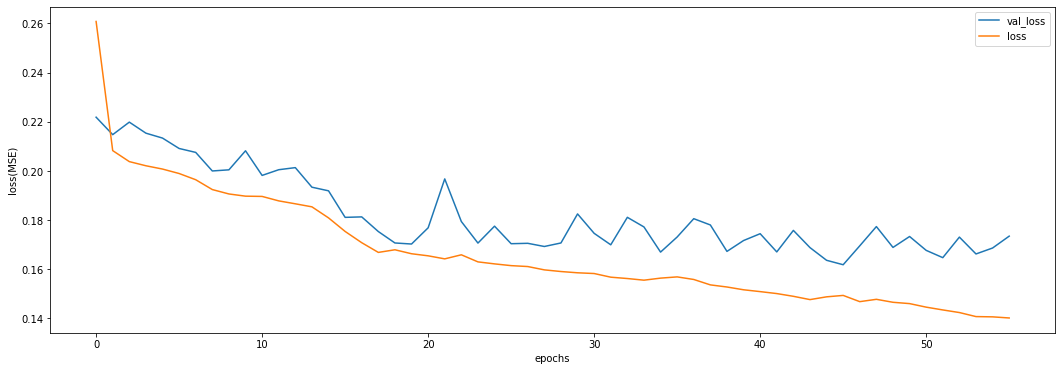

In [131]:
from numpy.random import seed



seed(1)
tf.random.set_seed(1)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features))))
model.add(RepeatVector(n_steps_out))
model.add(Bidirectional(LSTM(200, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

# where to store the init model weights
file_loc = make_folder()
mc = ModelCheckpoint(file_loc, monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

t0= time.clock()
# fit model
history = model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es,mc])
t1= time.clock() - t0
print('time taken:', t1)

saved_model = load_model(file_loc)
print('val loss:', saved_model.evaluate(val_X, val_y))
print('test loss:', saved_model.evaluate(test_X, test_y))



plot_history(history)

In [ ]:
saved_model = load_model(file_loc)

In [ ]:
saved_model.evaluate(val_X, val_y)

1/1 [==============================] - 0s 6ms/step - loss: 5.6837


5.683662414550781

In [ ]:
saved_model.evaluate(test_X, test_y)

2/2 [==============================] - 0s 14ms/step - loss: 7.0001


7.0000505447387695

In [ ]:
pred_input = test[-18:-6].reshape(1,12,6)

In [ ]:
prediction = model.predict(pred_input, verbose=1)

1/1 [==============================] - 0s 935us/step


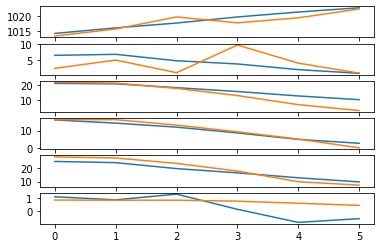

In [ ]:
fig, ax = plt.subplots(len(raw_data.columns),1)

for idx, col in enumerate(raw_data.columns):
  
  ax[idx].plot(prediction[0][:,idx])
  ax[idx].plot(test[-6:][:,idx])         


# use the saved weights as starting point

## UK53

In [134]:
file_loc = make_folder('best_LSTM.h5')
saved_model = load_model(file_loc)

In [135]:
site =  'UK53'

def get_split_data(site):
  raw_data = get_climate_ndvi_and_spei(site)
  dataset = norm_raw_data(raw_data)
  ttl_len = len(dataset)
  train = np.array(dataset.iloc[:int(ttl_len * 0.7)])
  val = np.array(dataset.iloc[int(ttl_len * 0.7):int(ttl_len * 0.8)])
  test = np.array(dataset.iloc[int(ttl_len * 0.8):])

  return (train, val, test)

train, val, test = get_split_data(site)

In [136]:
n_steps_in, n_steps_out = 12, 12

train_X, train_y = split_sequences(train, n_steps_in, n_steps_out)
val_X, val_y = split_sequences(val, n_steps_in, n_steps_out)
test_X, test_y = split_sequences(test, n_steps_in, n_steps_out)

# print(test)

n_features = train_X.shape[2]

In [137]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)
history = saved_model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=100, verbose=0, callbacks=[es])

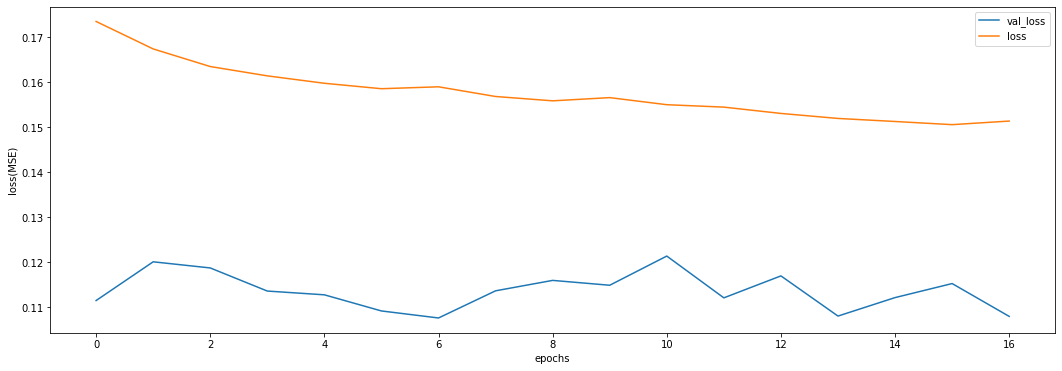

In [138]:
plot_history(history)

In [139]:
saved_model.evaluate(test_X, test_y)

2/2 [==============================] - 0s 16ms/step - loss: 0.1493


0.14926619827747345

## all interested sites

In [140]:
sites_of_interest

['MOT', 'ALWB', 'CEA', 'E45', 'FSAR', 'FSGA', 'GoS', 'SAGB', 'UK28', 'UK53']

In [144]:
from numpy.random import seed

seed(2)
tf.random.set_seed(1)

test_score_list = []

for idx, site in enumerate(sites_of_interest):
  if idx > 0:
    #load the best weights from BiLSTM
    file_loc = make_folder('best_LSTM.h5')
    saved_model = load_model(file_loc)

    train, val, test = get_split_data(site)
    n_steps_in, n_steps_out = 12, 12

    train_X, train_y = split_sequences(train, n_steps_in, n_steps_out)
    val_X, val_y = split_sequences(val, n_steps_in, n_steps_out)
    test_X, test_y = split_sequences(test, n_steps_in, n_steps_out)

    # to save the tuned weights
    file_loc2 = make_folder('temp.h5')
    mc = ModelCheckpoint(file_loc2, monitor='val_loss', mode='min', save_best_only=True)
    t0= time.clock()
    history = saved_model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=5, verbose=0, callbacks=[mc])
    t1= time.clock() - t0
    print('time taken:', t1)

    saved_model = load_model(file_loc2)
    test_score_list.append(saved_model.evaluate(test_X, test_y))

print('mean testing loss:', np.mean(test_score_list))

time taken: 6.817548999999417
2/2 [==============================] - 0s 12ms/step - loss: 0.1605
time taken: 6.726094000000558
2/2 [==============================] - 0s 10ms/step - loss: 0.1728
time taken: 6.428805000000466
2/2 [==============================] - 0s 14ms/step - loss: 0.1560
time taken: 6.5718690000003335
2/2 [==============================] - 0s 10ms/step - loss: 0.2048
time taken: 7.693409000000429
2/2 [==============================] - 0s 11ms/step - loss: 0.2033
time taken: 6.546831999999995
2/2 [==============================] - 0s 10ms/step - loss: 0.1764
time taken: 6.523376000000098
2/2 [==============================] - 0s 11ms/step - loss: 0.1462
time taken: 6.478243000000475
2/2 [==============================] - 0s 11ms/step - loss: 0.1431
time taken: 6.484120000000075
2/2 [==============================] - 0s 11ms/step - loss: 0.1585
mean testing loss: 0.1690481056769689
